In [41]:
import csv
import numpy as np
import utils
import hrr_utils
import time
import scipy

from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline 


N=1000

def genX(verbs):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))

    for m, pair in enumerate(verbs):
        past1 = hrr_utils.GetRVClipHash(pair[1], dic1, 3)
        past2 = hrr_utils.GetRVClipHash(pair[1], dic2, 3)
        pres1 = hrr_utils.GetRVClipHash(pair[0], dic1, 3)
        pres2 = hrr_utils.GetRVClipHash(pair[0], dic2, 3)
        PRES1[m] = pres1
        PRES2[m] = pres2
        PAST1[m] = past1
        PAST2[m] = past2

    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2


def closed_train(Past, Present):
    return np.dot(np.linalg.pinv(Present), Past)

def loss(W, X_train, y_train, lnum=1):
    lost = norm(np.dot(X_train,W) - y_train, lnum)
    return lost

def train(X_train, y_train, reg=0):
    ''' Build a model from X_train -> y_train '''
    xtx = X_train.T.dot(X_train)
    return scipy.linalg.solve(xtx + reg*np.eye(xtx.shape[0]), X_train.T.dot(y_train), sym_pos=True)

# no regularization yet
def train_gd(X_train, y_train, model, alpha=0.1, reg=0):
    ''' Build a model from X_train -> y_train using batch gradient descent 
        Gradient update equation: W = W.T(X.TX) - y.TX + 2alphaW.T
    '''
    
    gradient = 2*np.dot(model.T, np.dot(X_train.T,X_train))
    gradient -= 2*np.dot(y_train.T,X_train)
    gradient += 2*reg*model.T
    gradient = gradient.T/X_train.shape[0]
    model = model - alpha * gradient
    return model

def train_sgd(X_train, y_train, model, i, alpha=0.1, reg=0):
    ''' Build a model from X_train -> y_train using stochastic gradient descent 
        Gradient update equation: W = W.T(X[i].TX[i]) - y[i].TX[i] + 2alphaW.T
    '''
    #i = int(np.random.uniform(low=0,high=X_train.shape[0]))
    gradient = 2*np.dot(model.T, np.outer(X_train[i,:].T, X_train[i,:]))
    gradient -= 2*np.outer(y_train[i,:].T, X_train[i,:].T)
    gradient += 2*reg*model.T
    gradient = gradient.T/X_train.shape[0]
    model += model - alpha * gradient
    
    return model

def predict(model, X):
    ''' From model and data points, output prediction vectors '''
    return X.dot(model)

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def graph(x, y1, y2, title=None, xlabel='number of words', ylabel='average dot product', legend='upper right'):

    fig = plt.figure(figsize=(4,3))
    plt.plot(x, y1, label="train")
    plt.plot(x, y2, label="test")
    fig.suptitle(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(loc=legend)
    plt.show()
    #fig.savefig('test.jpg')

In [42]:
reg_pres, reg_past, reg_freq = utils.GetRegularVerbs(frequency=1)
irreg_pres, irreg_past, irreg_freq = utils.GetIrregularVerbs(frequency=1)

data_size = 100
reg_pres, reg_past, reg_freq = reg_pres[:data_size], reg_past[:data_size], reg_freq[:data_size]
irreg_pres, irreg_past, irreg_freq = irreg_pres[:data_size], irreg_past[:data_size], irreg_freq[:data_size]

regular = zip(reg_pres, reg_past, reg_freq)
irregular = zip(irreg_pres, irreg_past, irreg_freq)

#train_cutoff = 1700
train_cutoff = 70

train_reg = regular[0:train_cutoff]
train_irreg = irregular[0:train_cutoff]


test_reg = regular[train_cutoff:]
test_irreg = irregular[train_cutoff:]

dic1 = hrr_utils.GenerateDefaultDictionary(N)
dic2 = hrr_utils.GenerateDefaultDictionary(N)

regular.extend(irregular)
verbs = regular

In [43]:
trainX, trainpres1, trainpres2, trainpast1, trainpast2 = genX(train_reg + train_irreg)
testX, testpres1, testpres2, testpast1, testpast2 = genX(test_reg + test_irreg)

In [50]:
def online_regression(Past, Present, reg=1):
    inv_cov = np.linalg.inv(np.outer(Present, Present) + reg*np.eye(N))
    return inv_cov * np.outer(Present, Past)

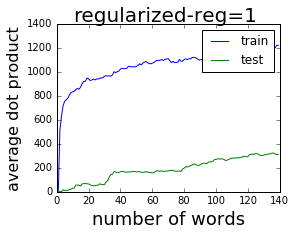

figures/regularized_trigam_regression-N=1000-W=140-reg=1-170426


In [51]:
W = np.zeros((N,N))

x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    y1[i] = sim(train_pred, trainpast2[:k]).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    W += online_regression(trainpast2[k], trainpres1[k])
    
graph(x,y1,y2,title='regularized-reg=1',legend='upper right')

fname =  ('figures/regularized_trigam_regression-N=' + str(N) + '-W=' + str(len(trainpres1)) + "-reg=1"
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)


Kernel Ridge Regression


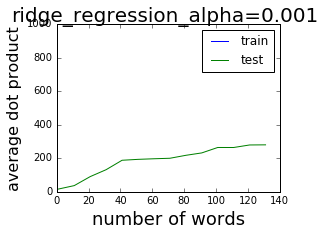

figures/trigam_kernel_ridge_regression-170426alpha=0.001
Kernel Ridge Regression


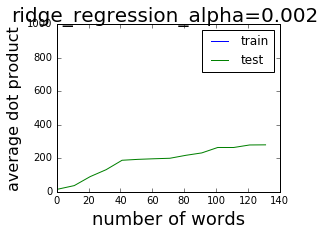

figures/trigam_kernel_ridge_regression-170426alpha=0.002
Kernel Ridge Regression


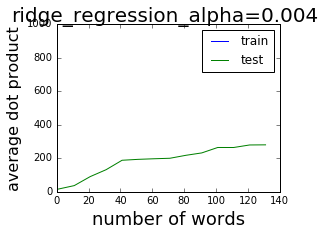

figures/trigam_kernel_ridge_regression-170426alpha=0.004
Kernel Ridge Regression


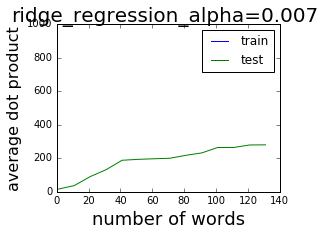

figures/trigam_kernel_ridge_regression-170426alpha=0.007
Kernel Ridge Regression


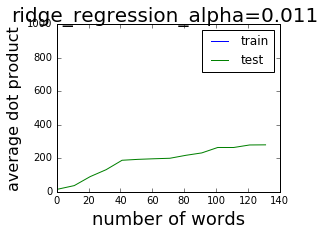

figures/trigam_kernel_ridge_regression-170426alpha=0.011
Kernel Ridge Regression


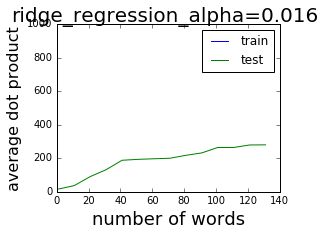

figures/trigam_kernel_ridge_regression-170426alpha=0.016
Kernel Ridge Regression


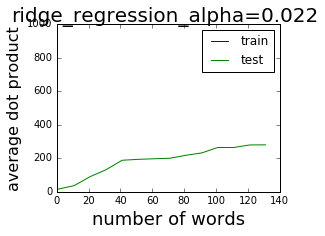

figures/trigam_kernel_ridge_regression-170426alpha=0.022
Kernel Ridge Regression


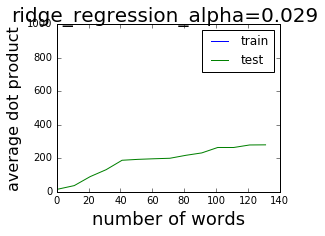

figures/trigam_kernel_ridge_regression-170426alpha=0.029
Kernel Ridge Regression


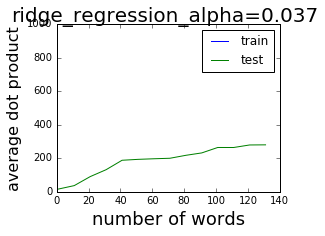

figures/trigam_kernel_ridge_regression-170426alpha=0.037
Kernel Ridge Regression


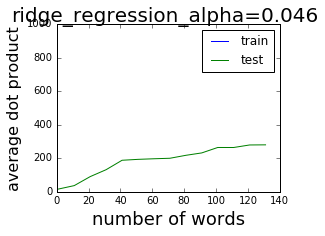

figures/trigam_kernel_ridge_regression-170426alpha=0.046


In [27]:
alpha=1e-3
kernels = ["linear", "laplacian", "polynomial", "sigmoid"]
clf = KernelRidge(alpha=alpha,kernel="polynomial")
# KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='linear', kernel_params=None)

for ad in range(10):
    alpha += ad*1e-3
    x = np.arange(1, trainpres1.shape[0], 10)
    y1 = np.zeros(x.shape[0])
    y2 = np.zeros(x.shape[0])

    print("Kernel Ridge Regression")
    W = np.zeros((N,N))
    for i in range(x.shape[0]):
        k = x[i]
        
        clf.fit(trainpres1[:k], trainpast2[:k]) 
        
        train_pred = clf.predict(trainpres1[:k])
        test_pred = clf.predict(testpres1)

        y1[i] = sim(train_pred, trainpast2[:k]).mean()
        y2[i] = sim(test_pred, testpast2).mean()
        
    graph(x,y1,y2,title='ridge_regression_alpha='+str(alpha),legend='upper right')

    fname =  ('figures/trigam_kernel_ridge_regression') + '-' + time.strftime('%y%m%d') + 'alpha=' + str(alpha)
    print fname

    plt.savefig(fname + '.png', transparent=True)
    plt.savefig(fname + '.eps', transparent=True)

In [7]:
# alternative idea: add leastsquares soln by getting singular values from the soln. bc the directions will be generalized?
# online svd where the singular values is the regularization. u, v are the binding
# seems like another iteration of the paper then. another time....
def pcaw_train(past, present, num_pc=20):
    pp_pair = np.multiply(past, present)
    tst = time.time()
    pp_u, pp_s, pp_v = np.linalg.svd(pp_pair)
    #print 'Elapsed: ', time.time() - tst
    
    cidx = min(num_pc, pp_u.shape[1])
    return np.dot(pp_u[:, :cidx], pp_v[:cidx, :]).sum(axis=0)

def regression_train(past, present):
    w = np.linalg.lstsq(present, past)[0]
    return w



Stochastic gradient descent


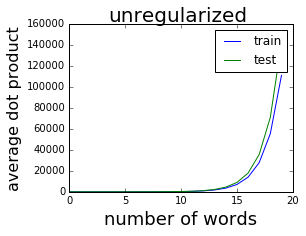

figures/unregularized_trigam_regression-170409


In [43]:
p = N
p_var = 0.015
alpha=1e-3
reg=0.1

x = np.arange(1, trainpres1.shape[0], 1)
x = np.arange(0, num_iter, 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

print("Stochastic gradient descent")
W = np.zeros((N,N))
for i in range(x.shape[0]):
    k = x[i]
    W = train_sgd(trainpres1, trainpast2, W, i, alpha, reg)
    train_pred = predict(W, trainpres1)
    test_pred = predict(W, testpres1)
    
    
    y1[i] = sim(train_pred, trainpast2).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    
    
graph(x,y1,y2,title='unregularized',legend='upper right')

fname =  ('figures/unregularized_trigam_regression') + '-' + time.strftime('%y%m%d')
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

Batch gradient descent


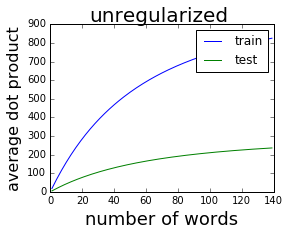

figures/unregularized_trigam_regression-170409


In [47]:
p = N
p_var = 0.015
alpha=1e-3
reg=0.1

x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

print("Batch gradient descent")
W = np.zeros((N,N))
for i in range(x.shape[0]):
    k = x[i]
    W = train_gd(trainpres1, trainpast2, W, alpha, reg)
    train_pred = predict(W, trainpres1)
    test_pred = predict(W, testpres1)
    
    
    y1[i] = sim(train_pred, trainpast2).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    
    
graph(x,y1,y2,title='unregularized',legend='upper right')

fname =  ('figures/unregularized_trigam_regression') + '-' + time.strftime('%y%m%d')
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)